## packages


In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import  LSTM

In [2]:
BASE_DIR = 'F:\cricket'
WORKING_DIR = 'F:\python_cricket'

## Extract Image feature

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())# load vgg16 model


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## extract features from image

In [44]:
#we can get image name so we store in one dict,reshaping,feature extraction 
features = {}
directory = os.path.join(BASE_DIR,'F:\cricket\cricket_dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #rgb
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0] #because atlast we have .jpg na so we dont want
    # store feature
    features[image_id] = feature

  0%|          | 0/570 [00:00<?, ?it/s]

In [43]:
import os
from PIL import Image
folder_path = 'F:\cricket'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path,'F:\cricket\cricket_dataset')
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('F:\cricket\cricket_dataset'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

## store features in pickle

In [45]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb')) #it will create one file inside the working directory through join as above we join both

## load features from pickle

In [12]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)


570

## Load the Captions Data

In [13]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f) #next is used because we dont want header
    captions_doc = f.read()

In [16]:
captions_doc


"1.jpg,The batsman has not crossed the line. \n2.jpg,The bail is in the air and its a clean bowled.\n3.jpg,the ball has hit the stump just before the batsman reaches the line.\n4.jpg,The batsman is far off from the white line.\n5.jpg,the stumps are glowing red and yes its a run out.\n6.jpg,Stumps glow red\n7.jpg,The ball has hit the stump and its glowing red.\n8.jpg,Far off from the line and its mostly a run out.\n9.jpg,Too close to the white line yet clean bowled.\n10.jpg,Ball has striked the stumps.\n11.jpg,Very close to the line but the stumps glow red.\n12.jpg,The ball has striked the stump before the batsman.\n13.jpg,Bat is very close to white line but not crossed so its a run out.\n14.jpg,Its a runout\n15.jpg,Ball has striked the stump its a runout\n16.jpg,clear run out\n17.jpg,bat not crossed the white line\n18.jpg,ball has striked the stump before the batsman could reach the line.\n19.jpg,its a run out.\n20.jpg,ball has striked the stump.\n21.jpg,Far off to score a run its a ru

In [17]:
# create mapping of image to captions
mapping = {} #here we are maping caption with image id
# process lines
for line in tqdm(captions_doc.split('\n')): #it is used to load a doc,directory something like iterating and n is used to split it line by line
    # split the line by comma(,)
    tokens = line.split(',')   #before ',' we have image id we dont want that so [0]--> image [1]-->caption
    
    if len(line) < 2:  #our caption should have greater than 2 words
        continue
    image_id, caption = tokens[0], tokens[1:] #we already said this and '1:' indicate we start from first word and goes on eg(this image shows a boy) 
    
    # remove extension from image ID
    image_id = image_id.split('.')[0]  #here extension .jpg we dont want that we already done like this
   
    # convert caption list to string
    caption = " ".join(caption)  #we extracted like a list so we change to string
    
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = [] #if we dont have that image caption means add that
    
    # store the caption
    mapping[image_id].append(caption) #one image has multiple caption so append that

  0%|          | 0/577 [00:00<?, ?it/s]

In [18]:
len(mapping) #so we have every image

569

## Preprocess Text Data (nlp)

In [19]:
def clean(mapping):
    for key, captions in mapping.items(): #here key is imageid and caption is ....
        for i in range(len(captions)):
            
            caption = captions[i] #here we take one caption at a time
            
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower() # converting to lower case
            
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '') #except alphabetics rejecting everything
            
            # delete additional spaces, it used to convert multiple spaces to single space
            caption = caption.replace('\s+', ' ') 
            
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq' #it something will combine start and end and also we remove some one letter word
            captions[i] = caption #here we replace in the main thing

In [20]:
# before preprocess of text
mapping['1']

['The batsman has not crossed the line. ']

In [21]:
# preprocess the text
clean(mapping)

In [22]:
# after preprocess of text
mapping['1']

['startseq the batsman has not crossed the line. endseq']

## Making a list

In [23]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption) #here we have entire captions in one list

In [24]:
len(all_captions)

569

In [25]:
all_captions[:6]

['startseq the batsman has not crossed the line. endseq',
 'startseq the bail is in the air and its clean bowled. endseq',
 'startseq the ball has hit the stump just before the batsman reaches the line. endseq',
 'startseq the batsman is far off from the white line. endseq',
 'startseq the stumps are glowing red and yes its run out. endseq',
 'startseq stumps glow red endseq']

## tokenizer

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 #from this we get the total unique word

In [27]:
vocab_size

487

In [28]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

19

## Train test split

In [55]:
from sklearn.model_selection import train_test_split
image_ids = list(mapping.keys()) 
split = int(len(image_ids) * 0.80)
#train = image_ids[:split]
#test = image_ids[split:]
#test

train, test = train_test_split(image_ids, random_state=50)
test

['364',
 '568',
 '290',
 '506',
 '372',
 '70',
 '560',
 '543',
 '93',
 '357',
 '480',
 '184',
 '280',
 '231',
 '291',
 '482',
 '101',
 '509',
 '576',
 '373',
 '197',
 '38',
 '212',
 '522',
 '222',
 '250',
 '502',
 '333',
 '366',
 '207',
 '394',
 '495',
 '24',
 '89',
 '210',
 '117',
 '472',
 '149',
 '581',
 '370',
 '275',
 '251',
 '331',
 '505',
 '483',
 '119',
 '433',
 '68',
 '479',
 '177',
 '155',
 '182',
 '84',
 '175',
 '118',
 '489',
 '225',
 '164',
 '115',
 '573',
 '519',
 '400',
 '239',
 '254',
 '43',
 '383',
 '154',
 '100',
 '492',
 '337',
 '442',
 '439',
 '130',
 '161',
 '544',
 '546',
 '403',
 '312',
 '173',
 '228',
 '260',
 '484',
 '50',
 '558',
 '39',
 '9',
 '532',
 '541',
 '288',
 '376',
 '16',
 '35',
 '409',
 '526',
 '341',
 '2',
 '91',
 '388',
 '12',
 '105',
 '113',
 '464',
 '448',
 '507',
 '542',
 '129',
 '80',
 '367',
 '200',
 '141',
 '214',
 '25',
 '271',
 '441',
 '353',
 '110',
 '17',
 '369',
 '361',
 '229',
 '524',
 '48',
 '196',
 '438',
 '297',
 '315',
 '287',
 '166'

In [56]:
#split

In [57]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]  #here for each word it will assign the index
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0] #to maintain same length we use pad because consider the eg at 1st we took girl as word... https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## model creation

In [58]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)  #here we pass inputs1 value as input and droupout .40 represent 40% chance of droping out 

fe2 = Dense(256, activation='relu')(fe1) #it is attached after convolution layer and it is deciding authority
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')   #to finding the error and optimizer is used to fix the error https://www.tutorialspoint.com/keras/keras_model_compilation.htm



In [59]:
# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


here in above we already used the image fillter extraction thats why we didnt applied here or otherwise we would


## train the model

In [80]:
epochs = 32  #number of complete passes through the training dataset.
batch_size = 16 #it will pass 32 images at 1 iteration

steps = len(train) // batch_size #at each step back propagation will be done that will handle automatically
 
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

26/26 [==============================] - 2s 90ms/step - loss: 0.0107


In [62]:
# save the model
model.save(WORKING_DIR+'/best_model.h5') 

In [63]:
import h5py

In [64]:
h5py.File("F:/python/best_model.h5",'r')

<HDF5 file "best_model.h5" (mode r)>

## Generate Captions for the Image

In [65]:
def idx_to_word(integer, tokenizer):   #because all caption we got in integer here it will convert to txt
    for word, index in tokenizer.word_index.items():
        if index == integer:    #if we have index value means we can use the word from dictionary 
            return word
    return None

In [66]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process to start
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]  #converting the input sequence of text to int
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0) #predicting the next word of the image
        
        # get index with high probability
        yhat = np.argmax(yhat)     #it will give the index which has high probablity
        
        # convert index to word
        word = idx_to_word(yhat, tokenizer) # here from above prob we are converting that respective integer to string
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word because we need to predict the next word too
        in_text += " " + word                    
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

## validate with test data

In [81]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()   #we need to compare original caption to predicted one

for key in tqdm(test):   #we need to take the test image caption
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
   
    # split into words
    actual_captions = [caption.split() for caption in captions]
    
    y_pred = y_pred.split()  #here we just need words in order to compare
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score  #BLEU (BiLingual Evaluation Understudy) is a metric for automatically evaluating machine-translated text. The BLEU score is a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations.
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/143 [00:00<?, ?it/s]

BLEU-1: 0.442831
BLEU-2: 0.219948


In [68]:
pickle.dump(predicted, open(os.path.join(WORKING_DIR, 'predicted.pkl'), 'wb'))
pickle.dump(actual, open(os.path.join(WORKING_DIR, 'actual.pkl'), 'wb'))

In [69]:
with open(os.path.join(WORKING_DIR, 'predicted.pkl'), 'rb') as f:
    predicted = pickle.load(f)
    
with open(os.path.join(WORKING_DIR, 'actual.pkl'), 'rb') as f:
    actual = pickle.load(f)

## Visualize the Results

In [82]:
from PIL import Image   #for loading the image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "F:\cricket\cricket_dataset", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq bat not crossed the white line endseq
--------------------Predicted--------------------
startseq batsman not crossed the line endseq


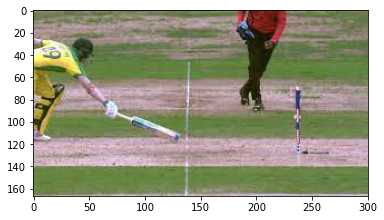

In [89]:
generate_caption('17.jpg')

In [32]:
###keras.models.load_model(filepath)

In [72]:
test

['364',
 '568',
 '290',
 '506',
 '372',
 '70',
 '560',
 '543',
 '93',
 '357',
 '480',
 '184',
 '280',
 '231',
 '291',
 '482',
 '101',
 '509',
 '576',
 '373',
 '197',
 '38',
 '212',
 '522',
 '222',
 '250',
 '502',
 '333',
 '366',
 '207',
 '394',
 '495',
 '24',
 '89',
 '210',
 '117',
 '472',
 '149',
 '581',
 '370',
 '275',
 '251',
 '331',
 '505',
 '483',
 '119',
 '433',
 '68',
 '479',
 '177',
 '155',
 '182',
 '84',
 '175',
 '118',
 '489',
 '225',
 '164',
 '115',
 '573',
 '519',
 '400',
 '239',
 '254',
 '43',
 '383',
 '154',
 '100',
 '492',
 '337',
 '442',
 '439',
 '130',
 '161',
 '544',
 '546',
 '403',
 '312',
 '173',
 '228',
 '260',
 '484',
 '50',
 '558',
 '39',
 '9',
 '532',
 '541',
 '288',
 '376',
 '16',
 '35',
 '409',
 '526',
 '341',
 '2',
 '91',
 '388',
 '12',
 '105',
 '113',
 '464',
 '448',
 '507',
 '542',
 '129',
 '80',
 '367',
 '200',
 '141',
 '214',
 '25',
 '271',
 '441',
 '353',
 '110',
 '17',
 '369',
 '361',
 '229',
 '524',
 '48',
 '196',
 '438',
 '297',
 '315',
 '287',
 '166'

In [ ]:
#509,118,35,97,17